<a href="https://colab.research.google.com/github/gaberm/TSA/blob/master/TSA_Forecasting_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting - Air Passengers Time Series Analysis

**Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras**

*Source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/*

**LSTM Time Series Forecasting Posts:**
The example in this post is quite dated, I have better examples available for using LSTMs on time series, see:

1. LSTMs for Univariate Time Series Forecasting
2. LSTMs for Multivariate Time Series Forecasting
3. LSTMs for Multi-Step Time Series Forecasting

---

Time series prediction problems are a difficult type of predictive modeling problem.

Unlike regression predictive modeling, time series also adds the complexity of a sequence dependence among the input variables.

A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained.

--2019-07-24 12:22:09--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2019-07-24 12:22:09 (54.3 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


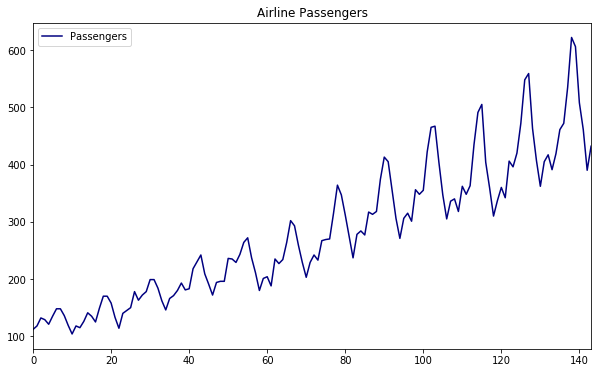

In [0]:
"""Forecasting - TSA Decomposition.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/gist/gaberm/3fc1f7ca17ac640e456844437bb1161a/forecasting-tsa-decomposition.ipynb

## Forecasting - Principles & Practices
by Rob J Hyndman and George Athanasopoulos - Monash University, Australia

Current Progress - https://otexts.com/fpp2/ts-objects.html

Python Exercises:
https://github.com/mscharth/forecasting

Useful links

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://rstudio-pubs-static.s3.amazonaws.com/311446_08b00d63cc794e158b1f4763eb70d43a.html
"""

import pandas as pd
import numpy as np
import matplotlib.pylab as plt


# %matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

#get the data
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

#load the data
dataframe = pd.read_csv('airline-passengers.csv')
print(dataframe.head())

dataframe.plot( title='Airline Passengers', colormap='jet')

###Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

* Forget Gate: conditionally decides what information to throw away from the block.
* Input Gate: conditionally decides which values from the input to update the memory state.
* Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

### LSTM Network for Regression
We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Before we get started, let’s first import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [0]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
# Create Numpy array of floats
# load the dataset
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

print(dataframe)

     Passengers
0           112
1           118
2           132
3           129
4           121
5           135
6           148
7           148
8           136
9           119
10          104
11          118
12          115
13          126
14          141
15          135
16          125
17          149
18          170
19          170
20          158
21          133
22          114
23          140
24          145
25          150
26          178
27          163
28          172
29          178
..          ...
114         491
115         505
116         404
117         359
118         310
119         337
120         360
121         342
122         406
123         396
124         420
125         472
126         548
127         559
128         463
129         407
130         362
131         405
132         417
133         391
134         419
135         461
136         472
137         535
138         622
139         606
140         508
141         461
142         390
143         432

[144 ro

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the **MinMaxScaler** preprocessing class from the scikit-learn library.



In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [0]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the **dataset**, which is a NumPy array that we want to convert into a dataset, and the **look_back**, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

The function output is to the original dataset sample listed in the previous section, you can see the X=t and Y=t+1 pattern in the numbers.

Let’s use this function to prepare the train and test datasets for modeling.

We can see the X=t and Y=t+1 pattern in the numbers.

Let’s use this function to prepare the train and test datasets for modeling.

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
print(trainX.shape, trainX)

(94, 1, 1) [[[0.01544401]]

 [[0.02702703]]

 [[0.05405405]]

 [[0.04826255]]

 [[0.03281853]]

 [[0.05984557]]

 [[0.08494207]]

 [[0.08494207]]

 [[0.06177607]]

 [[0.02895753]]

 [[0.        ]]

 [[0.02702703]]

 [[0.02123553]]

 [[0.04247104]]

 [[0.07142857]]

 [[0.05984557]]

 [[0.04054055]]

 [[0.08687258]]

 [[0.12741312]]

 [[0.12741312]]

 [[0.10424709]]

 [[0.05598456]]

 [[0.01930502]]

 [[0.06949806]]

 [[0.07915059]]

 [[0.08880308]]

 [[0.14285713]]

 [[0.11389962]]

 [[0.13127413]]

 [[0.14285713]]

 [[0.18339768]]

 [[0.18339768]]

 [[0.15444016]]

 [[0.11196911]]

 [[0.08108109]]

 [[0.1196911 ]]

 [[0.12934363]]

 [[0.14671814]]

 [[0.17181468]]

 [[0.14864865]]

 [[0.15250966]]

 [[0.22007722]]

 [[0.24324325]]

 [[0.26640925]]

 [[0.2027027 ]]

 [[0.16795367]]

 [[0.13127413]]

 [[0.17374519]]

 [[0.17760617]]

 [[0.17760617]]

 [[0.25482625]]

 [[0.25289574]]

 [[0.24131274]]

 [[0.26833975]]

 [[0.3088803 ]]

 [[0.32432434]]

 [[0.25675675]]

 [[0.20656371]]

 [[

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

W0723 23:53:01.467919 140352309520256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 23:53:01.517323 140352309520256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 23:53:01.523669 140352309520256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 23:53:01.727274 140352309520256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 23:53:01.943980 140352309520256 deprecation.py:323

Epoch 1/100
 - 5s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0202
Epoch 3/100
 - 0s - loss: 0.0146
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.92 RMSE
Test Score: 47.53 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

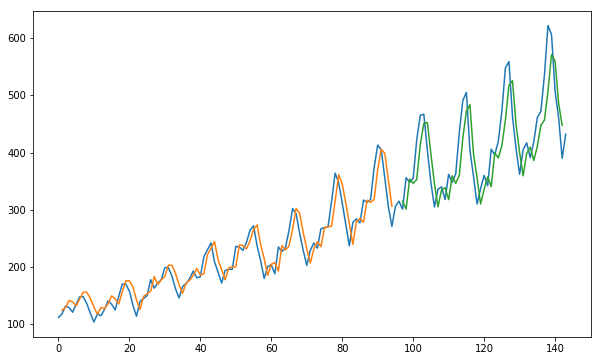

In [0]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the model has an average error of about 23 passengers (in thousands) on the training dataset, and about 52 passengers (in thousands) on the test dataset. Not that bad.

###LSTM for Regression Using the Window Method
We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

The **create_dataset**() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

A sample of the dataset with this formulation looks as follows:
```
X1	X2	X3	Y
112	118	132	129
118	132	129	121
132	129	121	135
129	121	135	148
121	135	148	148
```
We can re-run the example in the previous section with the larger window size. The whole code listing with just the window size change is listed below for completeness.



Epoch 1/100
 - 1s - loss: 0.0542
Epoch 2/100
 - 0s - loss: 0.0259
Epoch 3/100
 - 0s - loss: 0.0167
Epoch 4/100
 - 0s - loss: 0.0145
Epoch 5/100
 - 0s - loss: 0.0129
Epoch 6/100
 - 0s - loss: 0.0116
Epoch 7/100
 - 0s - loss: 0.0105
Epoch 8/100
 - 0s - loss: 0.0094
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0074
Epoch 11/100
 - 0s - loss: 0.0066
Epoch 12/100
 - 0s - loss: 0.0060
Epoch 13/100
 - 0s - loss: 0.0056
Epoch 14/100
 - 0s - loss: 0.0052
Epoch 15/100
 - 0s - loss: 0.0050
Epoch 16/100
 - 0s - loss: 0.0049
Epoch 17/100
 - 0s - loss: 0.0046
Epoch 18/100
 - 0s - loss: 0.0045
Epoch 19/100
 - 0s - loss: 0.0045
Epoch 20/100
 - 0s - loss: 0.0043
Epoch 21/100
 - 0s - loss: 0.0043
Epoch 22/100
 - 0s - loss: 0.0042
Epoch 23/100
 - 0s - loss: 0.0042
Epoch 24/100
 - 0s - loss: 0.0042
Epoch 25/100
 - 0s - loss: 0.0040
Epoch 26/100
 - 0s - loss: 0.0041
Epoch 27/100
 - 0s - loss: 0.0040
Epoch 28/100
 - 0s - loss: 0.0040
Epoch 29/100
 - 0s - loss: 0.0039
Epoch 30/100
 - 0s - lo

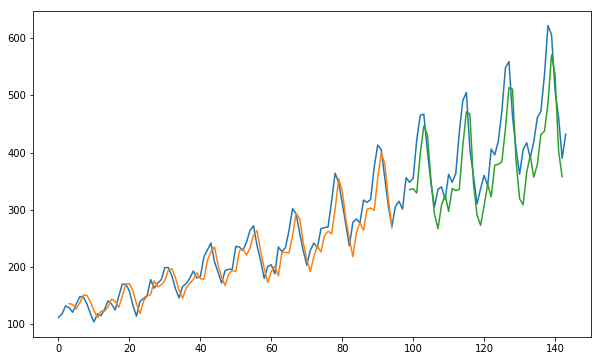

In [0]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the error was increased slightly compared to that of the previous section. The window size and the network architecture were not tuned: this is just a demonstration of how to frame a prediction problem.


###LSTM for Regression with Time Steps
You may have noticed that the data preparation for the LSTM network includes time steps.

Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1. For example:

Epoch 1/100
 - 2s - loss: 0.0285
Epoch 2/100
 - 1s - loss: 0.0117
Epoch 3/100
 - 1s - loss: 0.0097
Epoch 4/100
 - 1s - loss: 0.0086
Epoch 5/100
 - 1s - loss: 0.0074
Epoch 6/100
 - 1s - loss: 0.0065
Epoch 7/100
 - 1s - loss: 0.0058
Epoch 8/100
 - 1s - loss: 0.0053
Epoch 9/100
 - 1s - loss: 0.0045
Epoch 10/100
 - 1s - loss: 0.0044
Epoch 11/100
 - 1s - loss: 0.0041
Epoch 12/100
 - 1s - loss: 0.0041
Epoch 13/100
 - 1s - loss: 0.0040
Epoch 14/100
 - 1s - loss: 0.0039
Epoch 15/100
 - 1s - loss: 0.0039
Epoch 16/100
 - 1s - loss: 0.0039
Epoch 17/100
 - 1s - loss: 0.0038
Epoch 18/100
 - 1s - loss: 0.0039
Epoch 19/100
 - 1s - loss: 0.0038
Epoch 20/100
 - 1s - loss: 0.0038
Epoch 21/100
 - 1s - loss: 0.0038
Epoch 22/100
 - 1s - loss: 0.0038
Epoch 23/100
 - 1s - loss: 0.0037
Epoch 24/100
 - 1s - loss: 0.0038
Epoch 25/100
 - 1s - loss: 0.0037
Epoch 26/100
 - 1s - loss: 0.0038
Epoch 27/100
 - 1s - loss: 0.0037
Epoch 28/100
 - 1s - loss: 0.0038
Epoch 29/100
 - 1s - loss: 0.0037
Epoch 30/100
 - 1s - lo

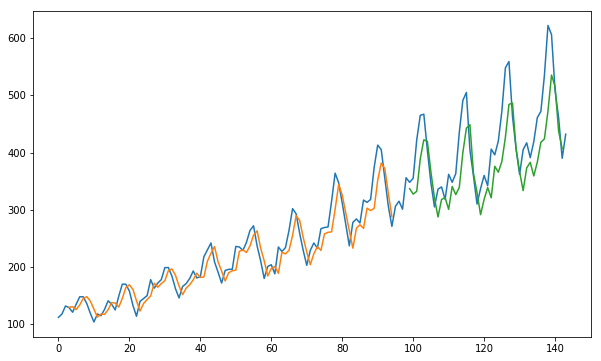

In [0]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM with Memory Between Batches
The LSTM network has memory, which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states(). For example:
```
for i in range(100):
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()
```

Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. For example:

```
model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))
```
This same batch size must then be used later when evaluating the model and making predictions. For example:

```
model.predict(trainX, batch_size=batch_size)
```

We can adapt the previous time step example to use a stateful LSTM. The full code listing is provided below.



Epoch 1/1
 - 2s - loss: 0.0048
Epoch 1/1
 - 1s - loss: 0.0082
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0048
Epoch 1/1
 - 1s - loss: 0.0047
Epoch 1/1
 - 1s - loss: 0.0047
Epoch 1/1
 - 1s - loss: 0.0047
Epoch 1/1
 - 1s - loss: 0.0046
Epoch 1/1
 - 1s - loss: 0.0045
Epoch 1/1
 - 1s - loss: 0.0045
Epoch 1/1
 - 1s - loss: 0.0044
Epoch 1/1
 - 1s - loss: 0.0043
Epoch 1/1
 - 1s - loss: 0.0043
Epoch 1/1
 - 1s - loss: 0.0042
Epoch 1/1
 - 1s - loss: 0.0042
Epoch 1/1
 - 1s - loss: 0.0041
Epoch 1/1
 - 1s - loss: 0.0041
Epoch 1/1
 - 1s - loss: 0.0040
Epoch 1/1
 - 1s - loss: 0.0040
Epoch 1/1
 - 1s - loss: 0.0039
Epoch 1/1
 - 1s - loss: 0.0038
Epoch 1/1
 - 1s - loss: 0.0037
Epoch 1/1
 - 1s - loss: 0.0037
Epoch 1/1
 - 1s - loss: 0.0036
Epoch 1/1
 - 1s - loss: 0.0035
Epoch 1/1
 - 1s - loss: 0.0034
Epoch 1/1
 - 1s - loss: 0.0033
Epoch 1/1
 - 1s - loss: 0.0032
Epoch 1/1
 - 1s - loss: 0.0032
Epoch 1/1
 - 1s - loss: 0.0031
Epoch 1/1
 - 1s - loss: 0.0030
Epoch 1/1
 - 1s - loss: 0.0029
Epoch 1/

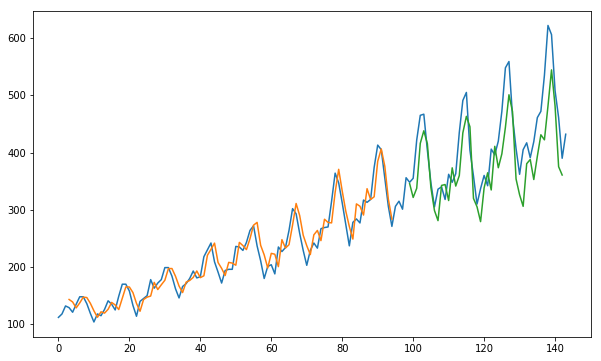

In [0]:
# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/1
 - 1s - loss: 0.0073
Epoch 1/1
 - 0s - loss: 0.0085
Epoch 1/1
 - 0s - loss: 0.0057
Epoch 1/1
 - 0s - loss: 0.0050
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/

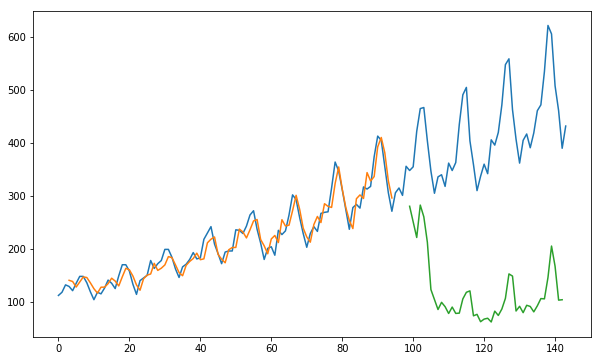

In [0]:
## Testing more epochs

# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 2
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Stacked LSTMs with Memory Between Batches
Finally, we will take a look at one of the big benefits of LSTMs: the fact that they can be successfully trained when stacked into deep network architectures.

LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the **return_sequences** parameter on the layer to **True**.

We can extend the stateful LSTM in the previous section to have two layers, as follows:



W0724 12:22:16.801187 140037329696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 12:22:16.853631 140037329696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 12:22:16.860513 140037329696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 12:22:17.362806 140037329696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 12:22:17.620277 140037329696640 deprecation.py:323

Epoch 1/1
 - 6s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0142
Epoch 1/1
 - 1s - loss: 0.0100
Epoch 1/1
 - 1s - loss: 0.0072
Epoch 1/1
 - 1s - loss: 0.0060
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/

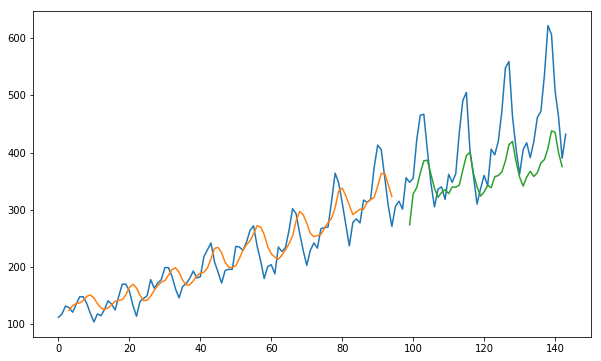

In [0]:
# Stacked LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/1
 - 2s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0142
Epoch 1/1
 - 1s - loss: 0.0100
Epoch 1/1
 - 1s - loss: 0.0072
Epoch 1/1
 - 1s - loss: 0.0060
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/

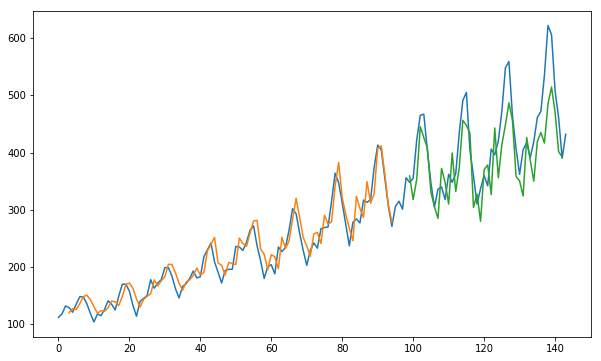

In [0]:
# Stacked LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=False, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
  
  
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data